In [6]:
%run setup_PS_data_multi.ipynb
import pandas as pd
import math, cmath
from tqdm import tqdm
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

ERROR:root:File `'setup_notebook.ipynb.py'` not found.


Now loading mouse RL070, run 22
error in mouse RL070, run 22
Now loading mouse RL070, run 23
error in mouse RL070, run 23
Now loading mouse RL070, run 24
error in mouse RL070, run 24
Now loading mouse RL070, run 27
error in mouse RL070, run 27
Now loading mouse RL070, run 28
microcontroller trial starts occur on average -33.28 ms from galvo trial starts
error in mouse RL070, run 28
Now loading mouse RL070, run 29
microcontroller trial starts occur on average nan ms from galvo trial starts
error in mouse RL070, run 29
Now loading mouse J047, run 7
error in mouse J047, run 7
Now loading mouse J048, run 15
error in mouse J048, run 15
Now loading mouse J048, run 16
error in mouse J048, run 16
Now loading mouse J048, run 18
error in mouse J048, run 18
Now loading mouse J048, run 19
error in mouse J048, run 19
Now loading mouse J048, run 26
error in mouse J048, run 26
Now loading mouse J048, run 27
microcontroller trial starts occur on average -36.39 ms from galvo trial starts
number of pre 

error in mouse J065, run 15
------------------------------------
7 sessions are loaded


In [16]:
sessions[0].run

# START

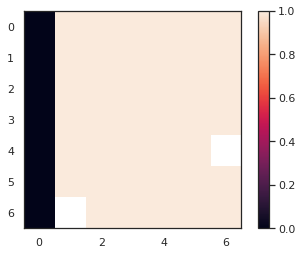

In [2]:


def beh_metric(sessions, metric='accuracy',
               stim_array=[0, 5, 10, 20, 30, 40, 50]):
    acc = np.zeros((len(sessions), len(stim_array)))
    for i_session, session in sessions.items():
        for i_stim, stim in enumerate(stim_array):
            trial_inds = np.where(session.trial_subsets == stim)[0]
            tp = np.sum(session.outcome[trial_inds] == 'hit')
            fp = np.sum(session.outcome[trial_inds] == 'fp')
            tn = np.sum(session.outcome[trial_inds] == 'cr')
            fn = np.sum(session.outcome[trial_inds] == 'miss')
            assert (tp + fp + tn + fn) == len(session.outcome[trial_inds])
            if metric == 'accuracy':
                acc[i_session, i_stim] = (tp + tn) / (tp + fp + tn + fn)
            elif metric == 'sensitivity':
                acc[i_session, i_stim] = tp / (tp + fp)
    return acc

plt.imshow(beh_metric(sessions=sessions, metric='sensitivity'))
plt.colorbar()

In [3]:
  # determine regularizer param with CV on training data
  #NB: have not tried to implement this yet
  # train /test  folds

def fun_return_2d(data):  # possibly add fancy stuff
    return np.mean(data, 2)

def angle_vecs(v1, v2):
    assert v1.shape == v2.shape
    v1, v2 = np.squeeze(v1), np.squeeze(v2)
    tmp = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    rad = np.arccos(tmp)
    deg = rad * 360 / (2 * np.pi)
    return deg

def mean_angle(deg):
    return math.degrees(cmath.phase(sum([cmath.rect(1, math.radians(d)) for d in deg])/len(deg)))


def create_dict_pred(nl, train_proj, lt):
        dict_predictions_test = {x + '_test': np.array([]) for x in nl}  # make dicts to save
        dict_predictions_train = {x + '_train': np.array([]) for x in nl}
        if train_proj:
            for x in lt:
                dict_predictions_train[f'pred_{x}_train_proj'] = np.array([])
                dict_predictions_test[f'pred_{x}_test_proj'] = np.array([])
        if len(lt) == 2:
            dict_predictions_train['angle_decoders'] = np.array([])
        return dict_predictions_train, dict_predictions_test

# for ii in range(len(sessions)):
#     sessions[ii].shuffle_labels()


In [4]:
def train_test_all_sessions(sessions, trial_times_use=None, verbose=2, list_test = ['dec', 'stim'],
                            hitmiss_only=False, cv_regularizer = False, include_150 = False,
                            n_split = 4, include_autoreward=True, neurons_selection='all',
                            C_value=0.2, train_projected=False):
    if hitmiss_only:
        if verbose >= 1:
            print('Using hit/miss trials only.')
        if 'stim' in list_test:
            list_test.remove('stim')  # no point in estimating stim, because only PS
            
    name_list = ['autorewarded']  # names of details to save - whether autorewrd trial or not
    for nn in list_test:
        name_list.append('pred_' + nn)  # prediction
    for nn in ['dec', 'stim']:
        name_list.append('true_' + nn)  # ground truth
        
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    df_prediction_train, df_prediction_test = dict(), dict()
    if cv_regularizer:
        best_c = {f'{x.mouse}R{x.run_number}': {} for _, x in sessions.items()}
    for mouse in mouse_list:
        angle_decoders = np.zeros((len(sessions), n_split))
        dict_predictions_train, dict_predictions_test = create_dict_pred(nl=name_list, train_proj=train_projected, lt=list_test)
        for i_session, session in sessions.items():  # loop through sessions/runs and concatenate results (in dicts)
            if session.mouse == mouse:  # only evaluate current mouse
                if verbose >= 1:
                    print(f'Mouse {mouse}, Starting loop {i_session + 1}/{len(sessions)}')
                if trial_times_use is None:
                    trial_times_use = session.filter_ps_array[(session.final_pre_gap_tp + 1):(session.final_pre_gap_tp + 6)]
                    print('WARNING: trial_times undefined so hard-coding them (to 5 post-stim frames)')
                n_trial_times_used = len(trial_times_use)

                ## Set neuron inds
                if neurons_selection == 'all':
                    neurons_include = np.arange(session.behaviour_trials.shape[0])
                elif neurons_selection == 's1':
                    neurons_include = session.s1_bool
                elif neurons_selection == 's2':
                    neurons_include = session.s2_bool

                ## Set trial inds
                if include_150 is False:
                    trial_inds = np.where(session.photostim < 2)[0]
                else:
                    trial_inds = np.arange(len(session.photostim))

                if hitmiss_only:
                    hitmiss_trials = np.where(np.logical_or(sessions[0].outcome == 'hit', sessions[0].outcome == 'miss'))[0]
                    if verbose == 2:
                        print(f'Size hm {hitmiss_trials.size}, trial inds {trial_inds.size}')
                    trial_inds = np.intersect1d(trial_inds, hitmiss_trials)

                if include_autoreward is False:
                    ar_exclude = np.where(session.autorewarded == False)[0]
                    if verbose == 2:
                        print(f'{np.sum(session.autorewarded)} autorewarded trials found and excluded')
                    trial_inds = np.intersect1d(trial_inds, ar_exclude)

                if verbose == 2:
                    print(f'final size {trial_inds.size}')
                n_trials = len(trial_inds)
                if verbose == 2:
                    print(f'Total number of trials is {n_trials}. Number of splits is {n_split}')

                # Prepare data with selections
                data_use = session.behaviour_trials[neurons_include, :, :]
                data_use = data_use[:, :, trial_times_use]
                data_use = data_use[:, trial_inds, :]
                data_use = fun_return_2d(data_use)
                stand_scale = sklearn.preprocessing.StandardScaler()
                data_use = stand_scale.fit_transform(data_use)
  
                sss = sklearn.model_selection.StratifiedKFold(n_splits=n_split)  # split into n_split data folds of trials
                if verbose == 2:
                    print(f'Number of licks: {np.sum(session.decision[trial_inds])}')
                    dict_outcomes = {x: np.sum(session.outcome[trial_inds] == x) for x in np.unique(session.outcome[trial_inds])}
                    print(f'Possible trial outcomes: {dict_outcomes}')
                    dict_n_ps = {x: np.sum(session.trial_subsets[trial_inds] == x) for x in np.unique(session.trial_subsets[trial_inds])}
                    print(f'Possible stimulations: {dict_n_ps}')
                
                if cv_regularizer:
                    train_data = data_use
                    train_labels =  {'stim': session.photostim[trial_inds],
                               'dec': session.decision[trial_inds]}
                    reg_array = {'C': np.logspace(-4, 0, 20), 'class_weight': ['balanced']}
                    for x in list_test:
                        grid = sklearn.model_selection.GridSearchCV(sklearn.linear_model.LogisticRegression(),
                                                                    reg_array, cv=n_split, n_jobs=n_split)  # cv uses Strat K Fold
                        grid.fit(X=train_data.transpose(), y=train_labels[x])
                        best_c[f'{session.mouse}R{session.run_number}'][x] = grid.best_params_['C']
                    if verbose == 2:
                        print( best_c[f'{session.mouse}{session.run_number}'])
                    continue  ## Skip rest of training etc. 
                
                i_loop = 0
                for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=session.outcome[trial_inds]):  # loop through different train/test folds, concat results
                    train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
                    if i_loop == 0:
                        if verbose == 2:
                            print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

                    ## Get labels and categories of trials
                    train_labels = {'stim': session.photostim[trial_inds[train_inds]],
                                    'dec': session.decision[trial_inds[train_inds]]}
                    test_labels = {'stim': session.photostim[trial_inds[test_inds]], 
                                   'dec': session.decision[trial_inds[test_inds]]}
                    if verbose == 2:
                        print(f' Number of test licks {np.sum(test_labels["dec"])}')
                    detailed_ps_labels = session.trial_subsets[trial_inds]
                    autorewarded = session.autorewarded[trial_inds]
                    assert len(train_labels['dec']) == train_data.shape[1]
                    assert len(test_labels['stim']) == test_data.shape[1]

                    ## Train logistic regression model on train data
                    dec = {}
                    for x in list_test:
                        dec[x] = sklearn.linear_model.LogisticRegression(C=C_value, class_weight='balanced').fit(
                                        X=train_data.transpose(), y=train_labels[x])

                    if len(list_test) == 2:
                        angle_decoders[i_session, i_loop] = angle_vecs(dec[list_test[0]].coef_, dec[list_test[1]].coef_)

                    if train_projected:  # project and re decode
                        dec_proj = {}
                        assert len(list_test) == 2  # hard coded that len==2 further on
                        for i_x, x in enumerate(list_test):
                            i_y = 1 - i_x
                            y = list_test[i_y]
                            assert x != y
                            enc_vector = dec[y].coef_ / np.linalg.norm(dec[y].coef_)
                            train_data_proj = enc_vector.copy() * train_data.transpose()
                            test_data_proj = enc_vector.copy() * test_data.transpose()
                            dec_proj[x] = sklearn.linear_model.LogisticRegression(C=C_value, class_weight='balanced').fit(
                                            X=train_data_proj, y=train_labels[x])

                    ## Predict test data
                    pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
                    pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}
                    if train_projected:
                        pred_proba_train_proj = {x: dec_proj[x].predict_proba(X=train_data_proj)[:, 1] for x in list_test}
                        pred_proba_test_proj = {x: dec_proj[x].predict_proba(X=test_data_proj)[:, 1] for x in list_test}

                    ## Save results
                    for x in list_test: 
                        dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
                        dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
                        if train_projected:
                            dict_predictions_train[f'pred_{x}_train_proj'] = np.concatenate((dict_predictions_train[f'pred_{x}_train_proj'], pred_proba_train_proj[x]))
                            dict_predictions_test[f'pred_{x}_test_proj'] = np.concatenate((dict_predictions_test[f'pred_{x}_test_proj'], pred_proba_test_proj[x]))
                    if len(list_test) == 2:
                        dict_predictions_train['angle_decoders'] = np.concatenate((dict_predictions_train['angle_decoders'], np.zeros_like(pred_proba_train[x]) + angle_decoders[i_session, i_loop]))
                    dict_predictions_train['true_stim_train'] = np.concatenate((dict_predictions_train['true_stim_train'], detailed_ps_labels[train_inds]))
                    dict_predictions_test['true_stim_test'] = np.concatenate((dict_predictions_test['true_stim_test'], detailed_ps_labels[test_inds]))
                    dict_predictions_train['autorewarded_train'] = np.concatenate((dict_predictions_train['autorewarded_train'], autorewarded[train_inds]))
                    dict_predictions_test['autorewarded_test'] = np.concatenate((dict_predictions_test['autorewarded_test'], autorewarded[test_inds]))
                    dict_predictions_train['true_dec_train'] = np.concatenate((dict_predictions_train['true_dec_train'], train_labels['dec']))
                    dict_predictions_test['true_dec_test'] = np.concatenate((dict_predictions_test['true_dec_test'], test_labels['dec']))
                    i_loop += 1
                if verbose >= 1 and cv_regularizer:
                    print(f'C values: {best_c}')
        if cv_regularizer is False:
            if verbose == 2:
                print(f'length test: {len(dict_predictions_test["true_dec_test"])}')

            ## Put dictionary results into dataframes:
            df_prediction_train[mouse] = pd.DataFrame(dict_predictions_train)
            df_prediction_test[mouse] = pd.DataFrame(dict_predictions_test)
        else:
            if verbose >= 1:
                print(best_c)
                
    if cv_regularizer:
        return best_c   # NB output size changes
    else:
        return df_prediction_train, df_prediction_test
    
    
def plot_df_stats(df, xx, yy, hh, plot_line=True, xticklabels=None):
#     yy = yy + '_proj'
    if plot_line and hh is None:
        sns.pointplot(data=df, x=xx, y=yy, color='grey', ci='sd', label=None)
    elif plot_line and hh is not None:
        sns.pointplot(data=df, x=xx, y=yy, hue=hh, ci='sd', label=None)
#     elif plot_line and hh is not None:
    if hh is None:  
        tmp = sns.stripplot(x=xx, y=yy, hue=hh, data=df, linewidth=1, label=None, color='grey')
    else:  
        tmp = sns.stripplot(x=xx, y=yy, hue=hh, data=df, linewidth=1, label=None)
    if xticklabels is not None:
        tmp.set_xticklabels(xticklabels)

Mouse J048, Starting loop 1/7
Mouse J048, Starting loop 2/7
Mouse J048, Starting loop 3/7
Mouse J048, Starting loop 4/7
Mouse RL048, Starting loop 5/7
Mouse RL048, Starting loop 6/7
Mouse RL048, Starting loop 7/7


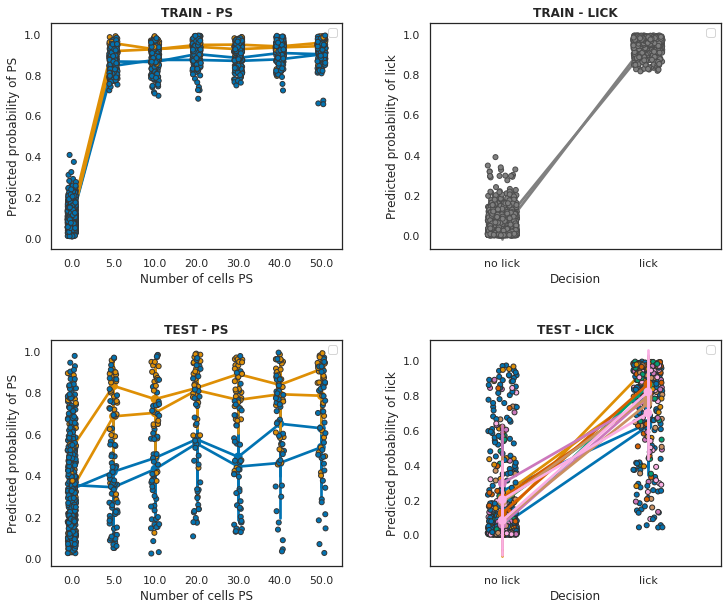

In [5]:
time_frame = 29
n_splits = 4

df_prediction_train, df_prediction_test = train_test_all_sessions(sessions=sessions, verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]),
                                         hitmiss_only=False,# list_test=['dec', 'stim'],
                                         include_autoreward=True, neurons_selection='s2',
                                         C_value=0.02, cv_regularizer=False, train_projected=True)

plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)

    
## NB: To not plot with hue, set hh=None
# for mouse in df_prediction_train.keys():
for mouse in ['J048', 'RL048']:
    if 'pred_stim_train' in df_prediction_train[mouse].columns:
        plt.subplot(221)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_stim_train', yy='pred_stim_train', hh='true_dec_train')  # set hh=None or hh='dec_train'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
        plt.legend([])

        plt.subplot(223)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
        plt.legend([])

    if 'pred_dec_train' in df_prediction_train[mouse].columns:  
        plt.subplot(222)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_dec_train', yy='pred_dec_train', hh=None, xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
        plt.legend('No lick', 'lick')

        plt.subplot(224)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_dec_test', yy='pred_dec_test', hh='true_stim_test', xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
        plt.legend([])
# plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
# #              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
#              f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

## Dynamic coding:

In [6]:
## Some functions that can be used as accuracy assessment 
def prob_correct(binary_truth, estimate):    
    """where bt = {0, 1} and est = (0, 1)"""
    prob = (binary_truth * estimate + (1 - binary_truth) * (1 - estimate))
    return prob

def mean_accuracy(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    return np.mean(pp), np.std(pp)

def mean_accuracy_pred(binary_truth, estimate):
    round_est = np.round(estimate)
    return sklearn.metrics.accuracy_score(binary_truth, round_est), 0

def llh(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    llh = np.mean(np.log(np.clip(pp, a_min=1e-3, a_max=1)))
    return llh, 0

def r2_acc(binary_truth, estimate):
    return sklearn.metrics.r2_score(y_true=binary_truth, y_pred=estimate), 0
                  
def separability(binary_truth, estimate):
    av_pred_0 = np.mean(estimate[binary_truth == 0])
    av_pred_1 = np.mean(estimate[binary_truth == 1])
    sep = av_pred_1 - av_pred_0
    return sep, 0

def min_mean_accuracy(binary_truth, estimate):
    mean_acc_true = np.mean(estimate[binary_truth == 1])
    mean_acc_false = 1 - np.mean(estimate[binary_truth == 0])
    return np.minimum(mean_acc_true, mean_acc_false), 0

## Main function to compute accuracy of decoders per time point
def compute_accuracy_time_array(sessions, time_array=None, average_fun=mean_accuracy, 
                                region_list=['s1', 's2'], regularizer=0.02, projected_data=False):
                                
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    if time_array is None:
        time_array = sessions[0].filter_ps_array
    stim_list = [0, 5, 10, 20, 30, 40, 50]  # hard coded!
    dec_list = [0, 1]  # hard_coded!! 
    mouse_s_list = []
    for mouse in mouse_list:
        for reg in region_list:
            mouse_s_list.append(mouse + '_' + reg)
    n_timepoints = len(time_array)

    lick_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} #mean, std
    lick_acc_split = {x: {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} for x in stim_list}  # split per ps conditoin
    lick_half = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list}  # naive with P=0.5 for 2 options (lick={0, 1})
    ps_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} 
    ps_acc_split = {x: {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} for x in dec_list}  # split per lick conditoin
    angle_dec = {mouse: np.zeros(n_timepoints) for mouse in mouse_s_list}
    for i_tp, tp in tqdm(enumerate(time_array)):
        for reg in region_list:
            df_prediction_train, df_prediction_test = train_test_all_sessions(sessions=sessions, trial_times_use=np.array([tp]), 
                                                          verbose=0, hitmiss_only=False,
                                                          include_autoreward=True, C_value=regularizer,
                                                          cv_regularizer=False, train_projected=projected_data,
                                                          neurons_selection=reg)

            for mouse in df_prediction_train.keys():
                lick = df_prediction_test[mouse]['true_dec_test']
                ps = (df_prediction_test[mouse]['true_stim_test'] > 0).astype('int')
                if projected_data is False:
                    pred_lick = df_prediction_test[mouse]['pred_dec_test'] 
                else:
                    pred_lick = df_prediction_test[mouse]['pred_dec_test_proj']  
                lick_half[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick, estimate=(np.zeros_like(lick) + 0.5))  # control for P=0.5
                lick_acc[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick, estimate=pred_lick)
#                 lick_acc[mouse + '_' + reg][i_tp, :] = 0
#                 for i_lick in np.unique(lick):
#                     lick_acc[mouse + '_' + reg][i_tp, :] += np.array(average_fun(binary_truth=lick[lick == i_lick], estimate=pred_lick[lick == i_lick])) / len(np.unique(lick))
                
                for x, arr in lick_acc_split.items():
                    arr[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]], 
                                              estimate=pred_lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]])

                if 'pred_stim_test' in df_prediction_test[mouse].columns:
                    if projected_data is False:
                        pred_ps = df_prediction_test[mouse]['pred_stim_test'] 
                    else:
                        pred_ps = df_prediction_test[mouse]['pred_stim_test_proj'] 
                    ps_acc[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=ps, estimate=pred_ps)
#                     ps_acc[mouse + '_' + reg][i_tp, :] = 0
#                     for i_ps in np.unique(lick):
#                         ps_acc[mouse + '_' + reg][i_tp, :] += np.array(average_fun(binary_truth=ps[lick == i_ps], estimate=pred_ps[lick == i_ps])) / len(np.unique(lick))

                    for x, arr in ps_acc_split.items():
                        arr[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=ps[lick == x], 
                                                  estimate=pred_ps[lick == x])
                angle_dec[mouse + '_' + reg][i_tp] = np.mean(df_prediction_train[mouse]['angle_decoders'])
                
    return (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, angle_dec)

In [7]:
## Compute results

(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
     angle_dec) = compute_accuracy_time_array(sessions=sessions, projected_data=False, 
                                              average_fun=mean_accuracy_pred)

56it [02:50,  3.04s/it]


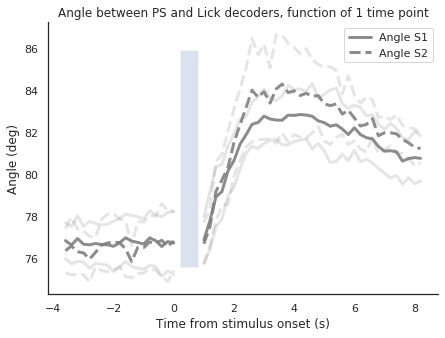

In [8]:
plt.rcParams['figure.figsize'] = (7, 5)
ax_acc = plt.subplot(111)

color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break
        
def plot_interrupted_trace(ax, time_array, plot_array, llabel='', bool_plot_std=False,
                           plot_laser=True, ccolor='grey', plot_indiv=True,
                           plot_groupav=True):
    breakpoint = sessions[0].art_gap_start
    time_1 = time_array[:breakpoint]
    time_2 = time_array[breakpoint:]
    
    mouse_list = list(plot_array.keys())
    linest = {'s1': '-', 's2': '--'}
    average_mean = {x: np.zeros(plot_array[mouse_list[0]].shape[0]) for x in region_list}
    for mouse in mouse_list:
        reg = mouse[-2:]
        if plot_array[mouse].ndim == 2:
            plot_mean = plot_array[mouse][:, 0]
        elif plot_array[mouse].ndim == 1:
            plot_mean = plot_array[mouse]
        average_mean[mouse[-2:]] += plot_mean / len(mouse_list) * 2
    #     plot_std = plot_array[:, 1]
    #     if bool_plot_std:
    #         ax_acc.fill_between(x=time_1, y1=plot_mean[:breakpoint] - plot_std[:breakpoint],
    #                            y2=plot_mean[:breakpoint] + plot_std[:breakpoint], color=ccolor, alpha=0.2)
    #         ax_acc.fill_between(x=time_2, y1=plot_mean[breakpoint:] - plot_std[breakpoint:],
    #                            y2=plot_mean[breakpoint:] + plot_std[breakpoint:], color=ccolor, alpha=0.2)
        if plot_indiv:
            ax_acc.plot(time_1, plot_mean[:breakpoint],  linewidth=3, linestyle=linest[reg], 
                        markersize=12, color=ccolor, label=None, alpha=0.2)
            ax_acc.plot(time_2, plot_mean[breakpoint:],  linewidth=3, linestyle=linest[reg], 
                        markersize=12, color=ccolor, alpha=0.2, label=None)
    if plot_groupav:
        for rr, av_mean in average_mean.items():
            ax_acc.plot(time_1, av_mean[:breakpoint],  linewidth=3, linestyle=linest[rr], 
                            markersize=12, color=ccolor, label=llabel + f' {rr.upper()}', alpha=0.9)
            ax_acc.plot(time_2, av_mean[breakpoint:], linewidth=3, linestyle=linest[rr], 
                        markersize=12, color=ccolor, alpha=0.9, label=None)
    if plot_laser:
        ax_acc.axvspan(xmin=time_1[-1] + 1 / freq, xmax=time_2[0] - 1 / freq, ymin=0.1, ymax=0.9, alpha=0.2, label=None)
    return ax_acc


mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
region_list=['s1', 's2']
freq = 5
new_time = (sessions[0].filter_ps_array - sessions[0].art_gap_start + 1) / freq

# if 'pred_dec_test' in df_prediction_test[mouse_list[0]].columns:
# plot_interrupted_trace(ax=ax_acc
#                        , plot_array=lick_acc, bool_plot_std=False,
#                        llabel='decision', ccolor=(0.00784313725490196, 0.6196078431372549, 0.45098039215686275))
# # if 'pred_stim_test' in df_prediction_test[mouse_list[0]].columns:
# plot_interrupted_trace(ax=ax_acc, plot_array=ps_acc, llabel='ps', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

# plot_dict_split = ps_acc_split
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, plot_array=dict_part, llabel=str(key), 
#                            ccolor=color_dict_stand[iplot], plot_indiv=True)

plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=angle_dec, llabel='Angle')

# plot_interrupted_trace(ax=ax_acc, plot_array=lick_half, bool_plot_std=False, llabel='0.5')
ax_acc.set_xlabel('Time from stimulus onset (s)'); ax_acc.set_ylabel('Angle (deg)')
ax_acc.legend(); ax_acc.set_title('Angle between PS and Lick decoders, function of 1 time point');
# plt.xlim([180, 220])
sns.despine()

In [9]:
tp_list = [15, 23, 33]
dict_df_test = {reg: {} for reg in region_list}
for reg in region_list:
    for tp in tp_list:
        _, dict_df_test[reg][tp] = train_test_all_sessions(sessions=sessions, verbose=0,# n_split=n_split,
                                                      trial_times_use=np.array([tp]),
                                                 hitmiss_only=False,# list_test=['dec', 'stim'],
                                                 include_autoreward=True, neurons_selection=reg,
                                                 C_value=0.02, cv_regularizer=False, train_projected=True)


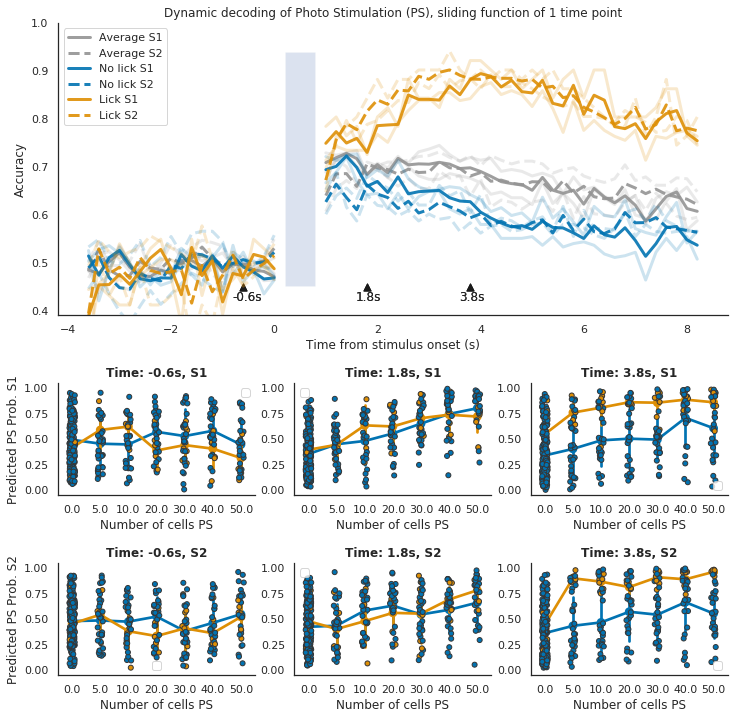

In [10]:
## Complete fig:

plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
plot_interrupted_trace(ax=ax_acc,  time_array=new_time, plot_array=ps_acc,
                       llabel='Average', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

plot_dict_split = ps_acc_split
label_split = {0: 'No lick', 1: 'Lick'}
for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
    dict_part = plot_dict_split[key]
    plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
                           ccolor=color_dict_stand[iplot], plot_indiv=True, plot_laser=False)

ax_acc.set_xlabel('Time from stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Photo Stimulation (PS), sliding function of 1 time point');
ax_acc.set_ylim([0.39, 1])
mouse = 'RL048'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        plot_df_stats(df=dict_df_test[reg][tp][mouse], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.title(f'Time: {new_time[tp]}s, {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 1.05])
        ax_acc.scatter([new_time[tp]], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{new_time[tp]}s', x=new_time[tp] - 0.22, y=0.42)
        if i_tp == 0:
             plt.ylabel(f'Predicted PS Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()

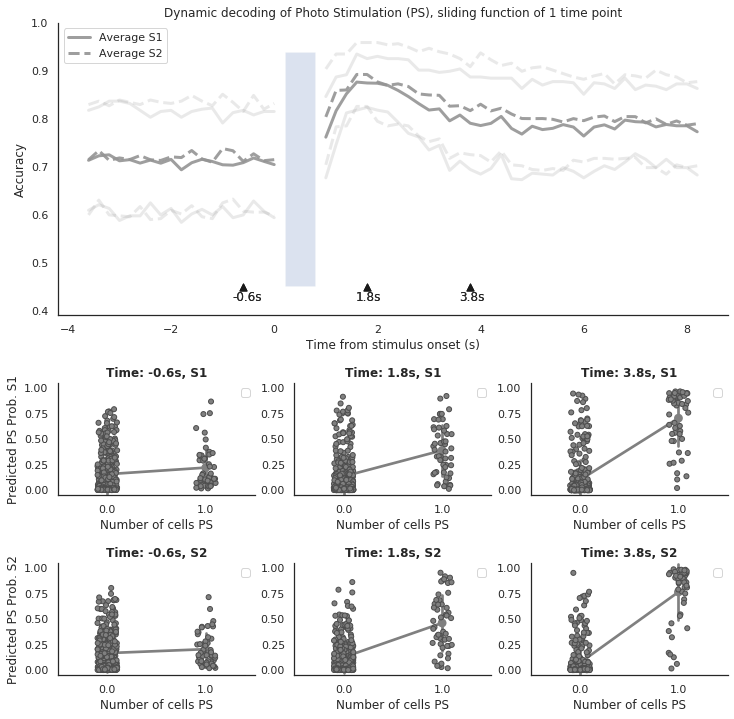

In [11]:
## Complete fig:

plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
plot_interrupted_trace(ax=ax_acc,  time_array=new_time,plot_array=lick_acc, llabel='Average', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

# plot_dict_split = ps_acc_split
# label_split = {0: 'No lick', 1: 'Lick'}
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
#                            ccolor=color_dict_stand[iplot], plot_indiv=True, plot_laser=False)

ax_acc.set_xlabel('Time from stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Photo Stimulation (PS), sliding function of 1 time point');
ax_acc.set_ylim([0.39, 1])
# reg = 's2'
mouse = 'RL048'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        plot_df_stats(df=dict_df_test[reg][tp][mouse], xx='true_dec_test', yy='pred_dec_test', hh=None)  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.title(f'Time: {new_time[tp]}s, {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 1.05])
        ax_acc.scatter([new_time[tp]], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{new_time[tp]}s', x=new_time[tp] - 0.22, y=0.42)
        if i_tp == 0:
             plt.ylabel(f'Predicted PS Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()

In [13]:
sessions

{0: instance Mouse J048, run 27 of Session class,
 1: instance Mouse J048, run 28 of Session class,
 2: instance Mouse J048, run 30 of Session class,
 3: instance Mouse J048, run 32 of Session class,
 4: instance Mouse RL048, run 23 of Session class,
 5: instance Mouse RL048, run 24 of Session class,
 6: instance Mouse RL048, run 28 of Session class}

## ideas to improve / directions to go

#### Current plot:

- Quantify statistical significance between go/no go 
- S1 vs S2
- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)

- different integration of time points per neuron? (i.e. separate, some other function etc)

- Try to find something that relates PS decoding to licking decoding

#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- We don't really find a difference between S1/S2 performance (-> large population?)

- Use increasing/decreasing number of neurons